In [4]:
# import he required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import shap

sn.set()

In [5]:
df=pd.read_csv('Purchasing Card Data 2014 v1.csv') # load csv to dataframe
print(df.shape)
df.head()

(4142, 7)


,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,20/05/2014,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,20/05/2014,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,20/05/2014,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,20/05/2014,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,20/05/2014,306


In [6]:
df[df.duplicated(keep=False)] # shows duplicated rows

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value


### Exploratory data analysis

In [7]:
df['JV Value'] = df['JV Value'].str.replace(',','') # preprocess the data
df['JV Value']=pd.to_numeric(df['JV Value'])
df['JV Date']=pd.to_datetime(df['JV Date'])
df['Transaction Date']=pd.to_datetime(df['Transaction Date'])
df['JV Reference']=pd.to_numeric(df['JV Reference'])

In [8]:
df.head()

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93,2014-05-20,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111,2014-05-20,6000.00
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6,2014-05-20,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7,2014-05-20,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381,2014-05-20,306.00


In [9]:
df['transaction_month']=df['Transaction Date'].dt.month # extract day, month, year, weekday from the dates
df['transaction_day']=df['Transaction Date'].dt.day
df['transaction_weekday']=df['Transaction Date'].dt.day_name()
df['transaction_year']=df['Transaction Date'].dt.year
df['jv_month']=df['JV Date'].dt.month
df['jv_day']=df['JV Date'].dt.day
df['jv_weekday']=df['JV Date'].dt.day_name()
df['jv_year']=df['JV Date'].dt.year

df.head()

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value,transaction_month,transaction_day,transaction_weekday,transaction_year,jv_month,jv_day,jv_weekday,jv_year
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93,2014-05-20,143.81,4,23,Wednesday,2014,5,20,Tuesday,2014
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111,2014-05-20,6000.00,3,4,Tuesday,2014,5,20,Tuesday,2014
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6,2014-05-20,309.38,2,4,Tuesday,2014,5,20,Tuesday,2014
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7,2014-05-20,218.76,2,4,Tuesday,2014,5,20,Tuesday,2014
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381,2014-05-20,306.00,4,15,Tuesday,2014,5,20,Tuesday,2014


In [10]:
df.describe(include = 'all') # describes stats of the df

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value,transaction_month,transaction_day,transaction_weekday,transaction_year,jv_month,jv_day,jv_weekday,jv_year
count,4142,4142,4142,4142,4142.000000,4142,4142.000000,4142.000000,4142.000000,4142,4142.000000,4142.000000,4142.000000,4142,4142.000000
unique,23,38,834,237,NaN,11,NaN,NaN,NaN,7,NaN,NaN,NaN,5,NaN
top,Childrens Services,Equipment and Materials Purcha,Amazon Mktplce EU-U,2014-10-11 00:00:00,NaN,2014-06-17 00:00:00,NaN,NaN,NaN,Monday,NaN,NaN,NaN,Tuesday,NaN
freq,1297,961,254,64,NaN,447,NaN,NaN,NaN,891,NaN,NaN,NaN,2317,NaN
first,NaN,NaN,NaN,2014-01-05 00:00:00,NaN,2014-05-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2015-12-02 00:00:00,NaN,2015-03-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2692.612989,NaN,97.639044,6.623129,15.520763,NaN,2014.213423,6.652100,17.098986,NaN,2014.298407
std,NaN,NaN,NaN,NaN,1643.842740,NaN,386.644735,3.536224,8.360706,NaN,0.409774,3.614404,1.254349,NaN,0.457614
min,NaN,NaN,NaN,NaN,1.000000,NaN,-4707.000000,1.000000,1.000000,NaN,2014.000000,1.000000,16.000000,NaN,2014.000000
25%,NaN,NaN,NaN,NaN,1199.250000,NaN,9.500000,4.000000,9.000000,NaN,2014.000000,3.000000,16.000000,NaN,2014.000000


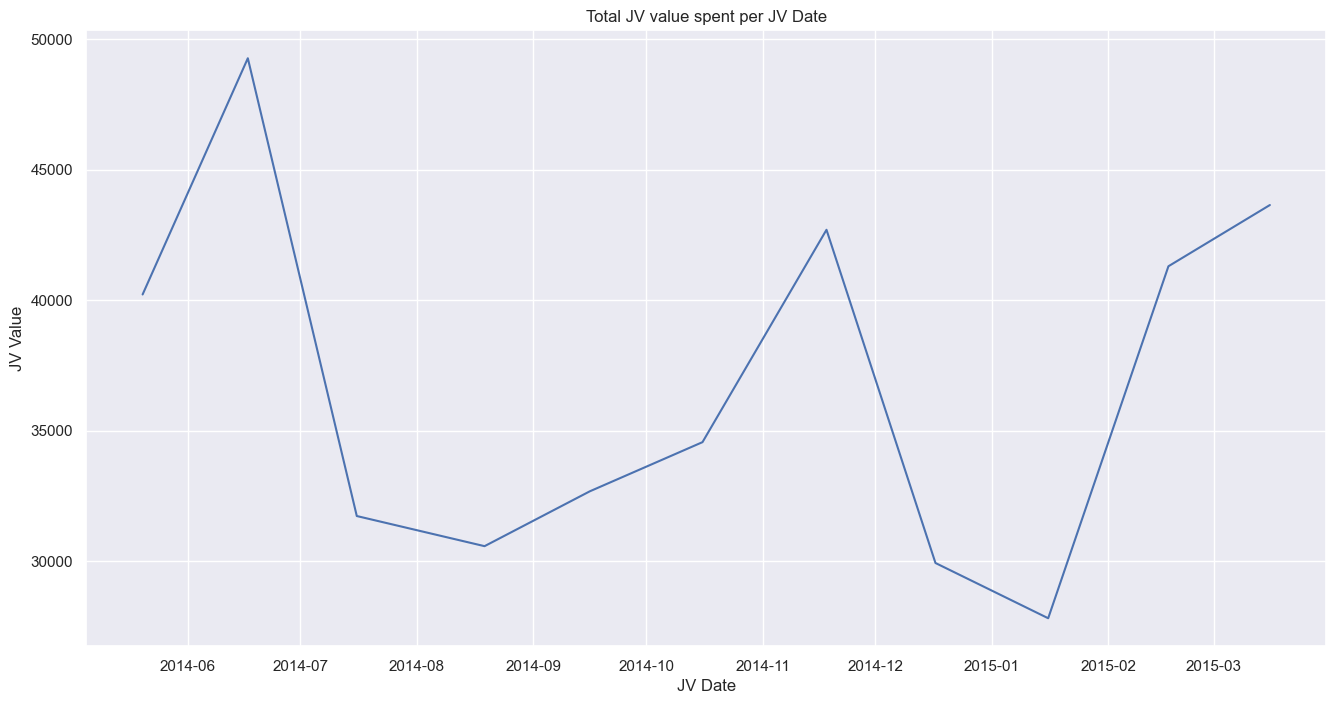

In [11]:
plt.figure(figsize=(16,8)) # plot the JV spendings by date
jv_grouped_by_date=df.groupby('JV Date',as_index=False).agg({'JV Value':'sum'}).sort_values('JV Date')
plt.plot(jv_grouped_by_date['JV Date'], jv_grouped_by_date['JV Value'])
plt.xlabel('JV Date')
plt.ylabel('JV Value')
plt.title("Total JV value spent per JV Date")
plt.show()

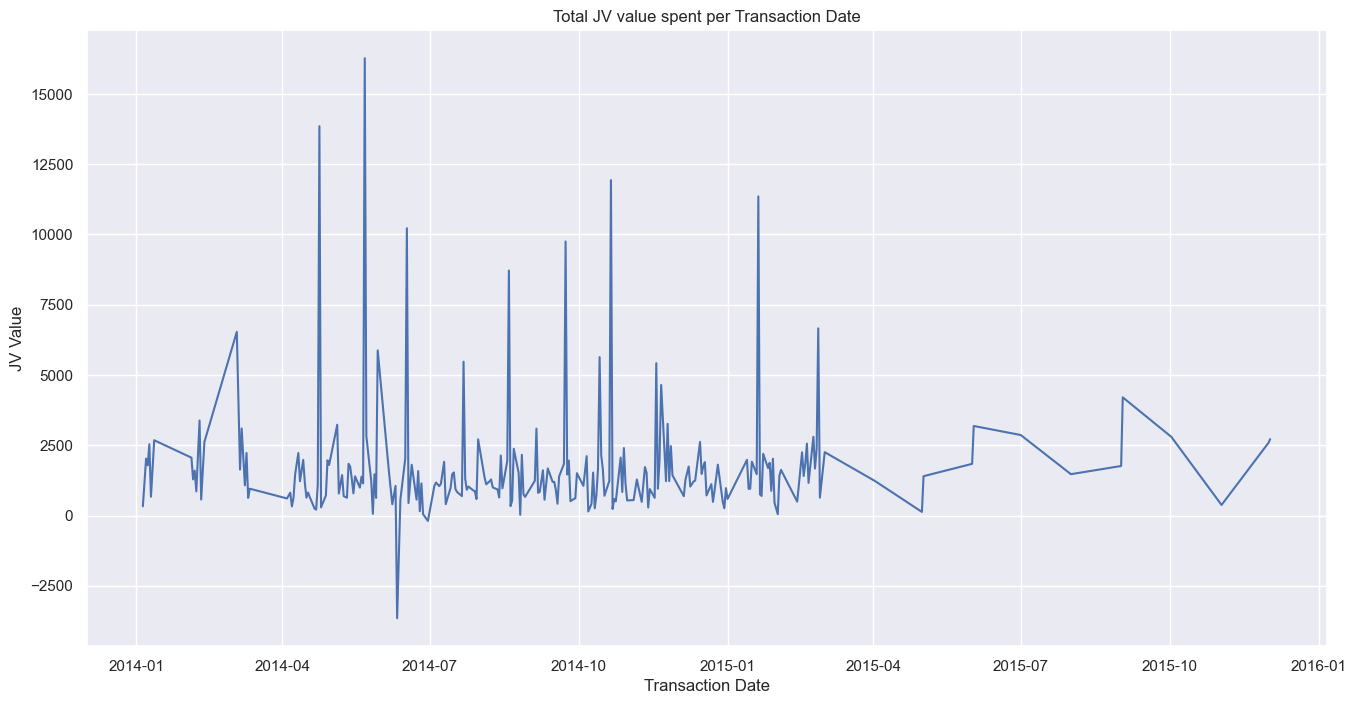

In [12]:
plt.figure(figsize=(16,8)) # plot the JV spendings by transaction date
jv_grouped_by_tr_date=df.groupby('Transaction Date',as_index=False).agg({'JV Value':'sum'}).sort_values('Transaction Date')
plt.plot(jv_grouped_by_tr_date['Transaction Date'], jv_grouped_by_tr_date['JV Value'])
plt.xlabel('Transaction Date')
plt.ylabel('JV Value')
plt.title("Total JV value spent per Transaction Date")
plt.show()

In [13]:
def show_bar_plot(df,columns_for_grouping,agg_column,agg_type,sort_by,xlabel,ylabel,title,top=50):
    "takes the df and groups by the columns given after aggregating by the column name"
    
    # get group by result
    grouped_df=df.groupby(columns_for_grouping,as_index=False).agg({agg_column:agg_type}).sort_values(sort_by,
                                                                                                ascending=False)
    
    plt.figure(figsize=(16,8))
    # show barplot
    if top!=0:
        plt.bar(grouped_df[columns_for_grouping][:50], grouped_df[agg_column][:50])
    else:
        plt.bar(grouped_df[columns_for_grouping], grouped_df[agg_column])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

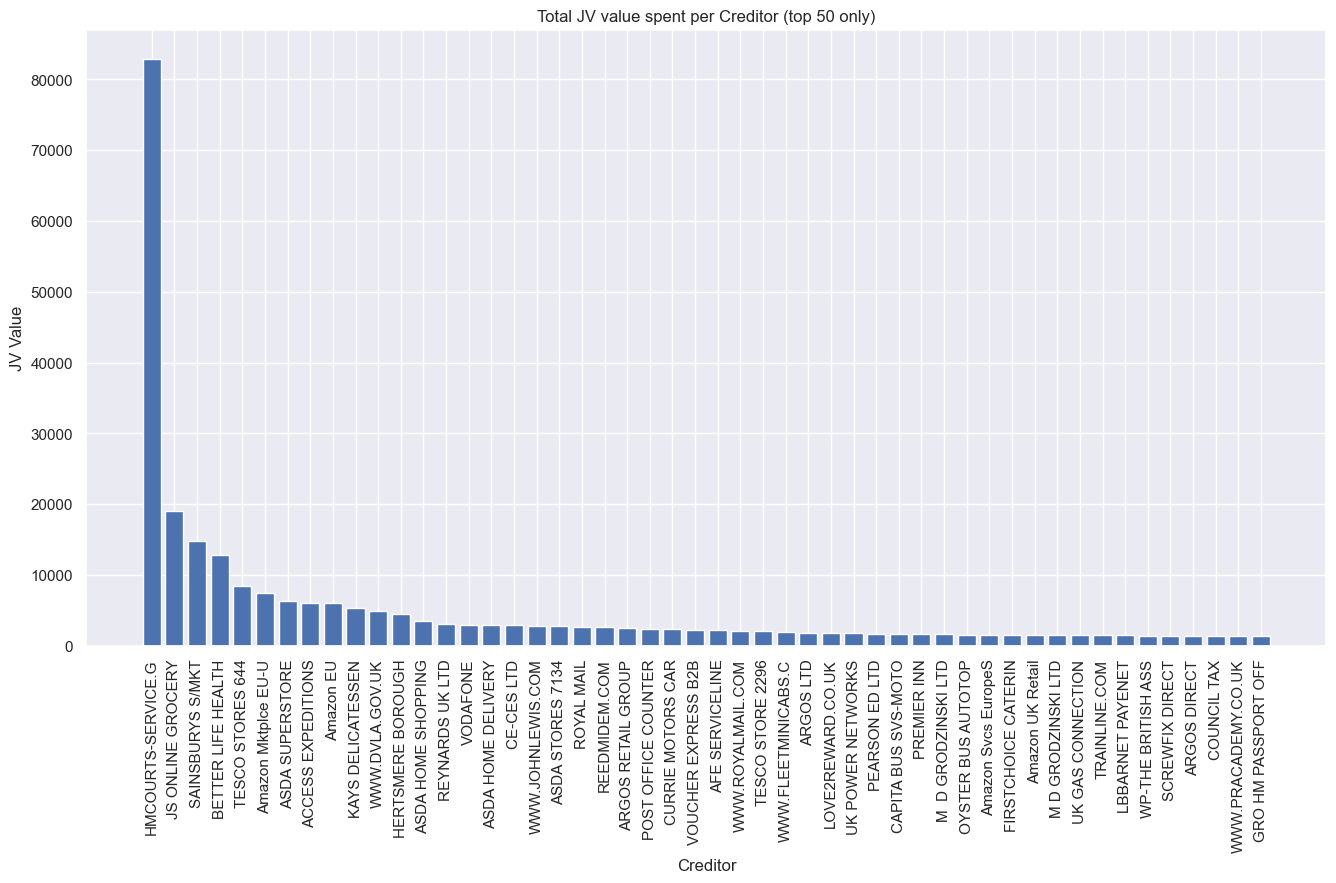

In [14]:
show_bar_plot(df,'Creditor', 'JV Value', 'sum', 'JV Value', 'Creditor', 
              'JV Value', "Total JV value spent per Creditor (top 50 only)")

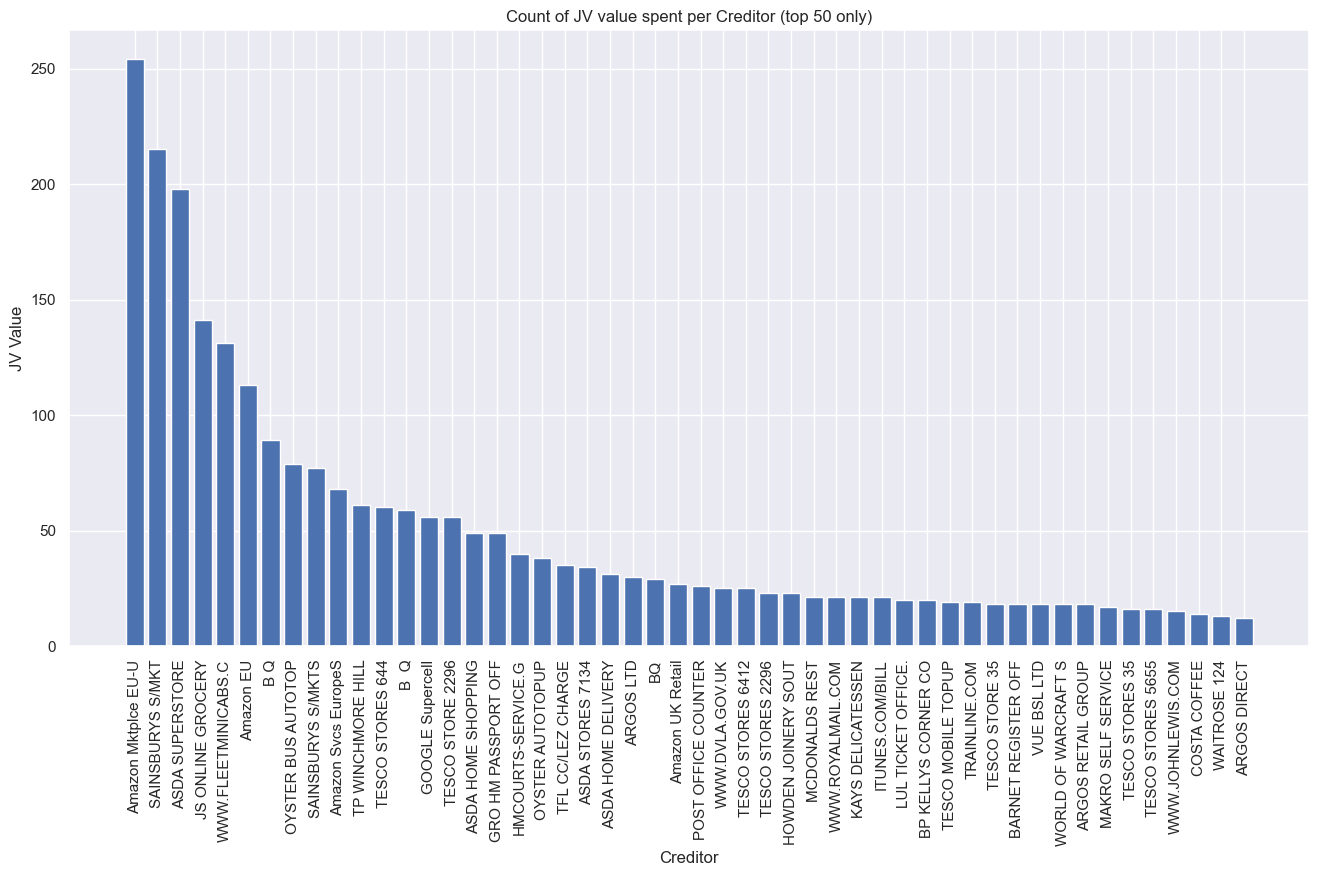

In [15]:
show_bar_plot(df,'Creditor', 'JV Value', 'count', 'JV Value', 'Creditor', 
              'JV Value', "Count of JV value spent per Creditor (top 50 only)")

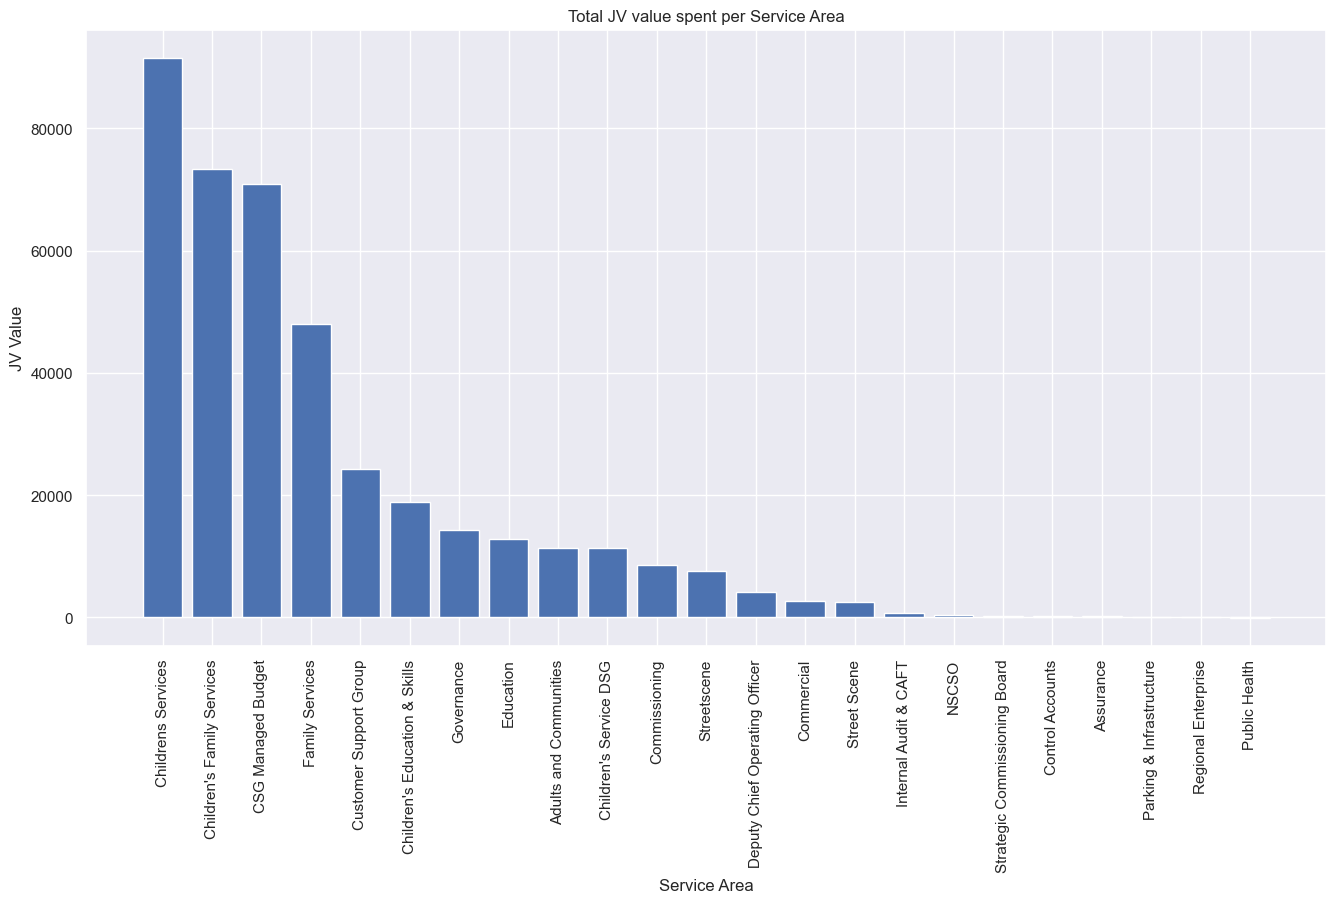

In [16]:
show_bar_plot(df,'Service Area', 'JV Value', 'sum', 'JV Value', 'Service Area', 
              'JV Value', "Total JV value spent per Service Area",top=0)

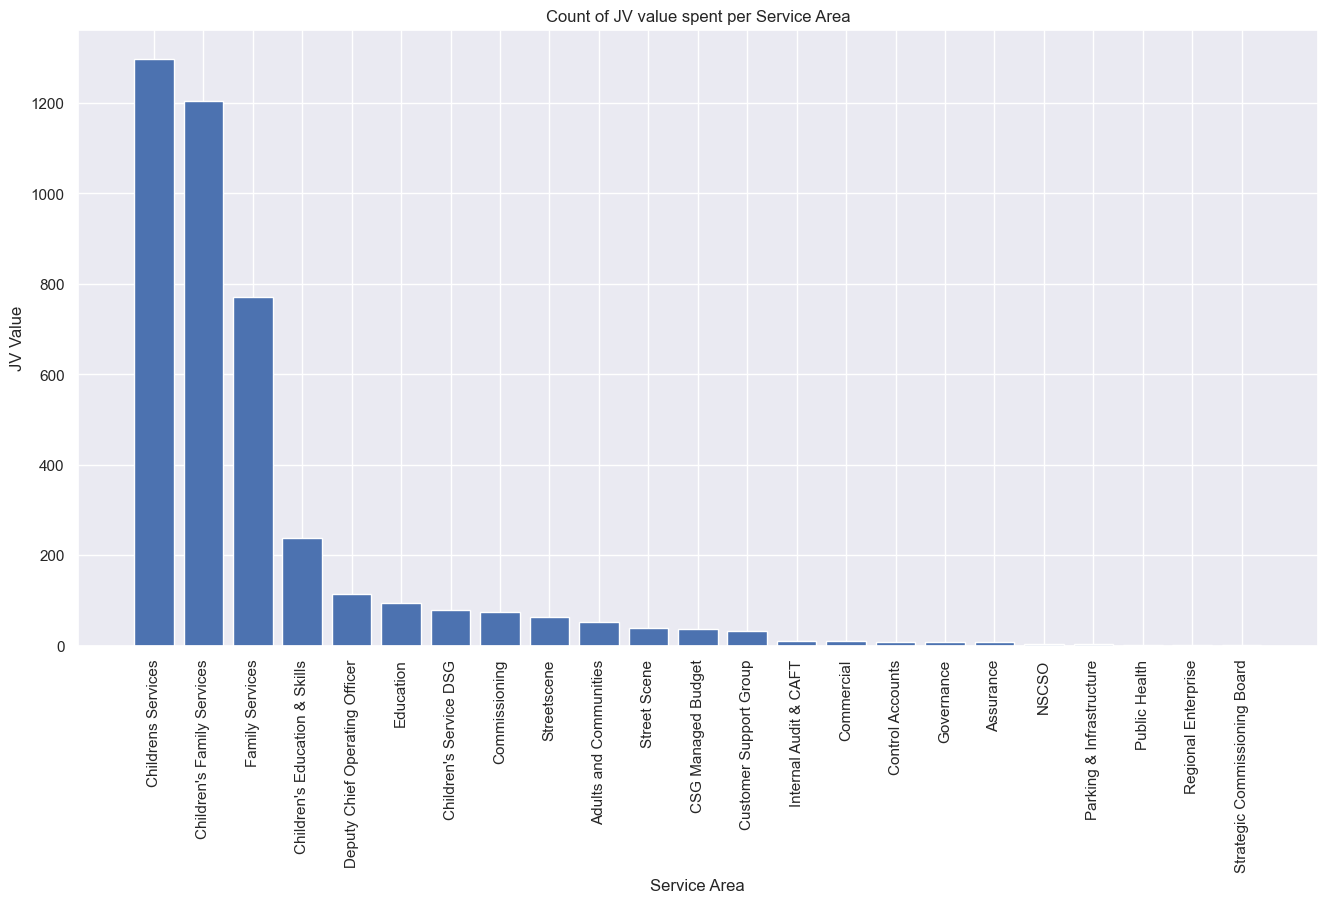

In [17]:
show_bar_plot(df,'Service Area', 'JV Value', 'count', 'JV Value', 'Service Area', 
              'JV Value', "Count of JV value spent per Service Area",top=0)

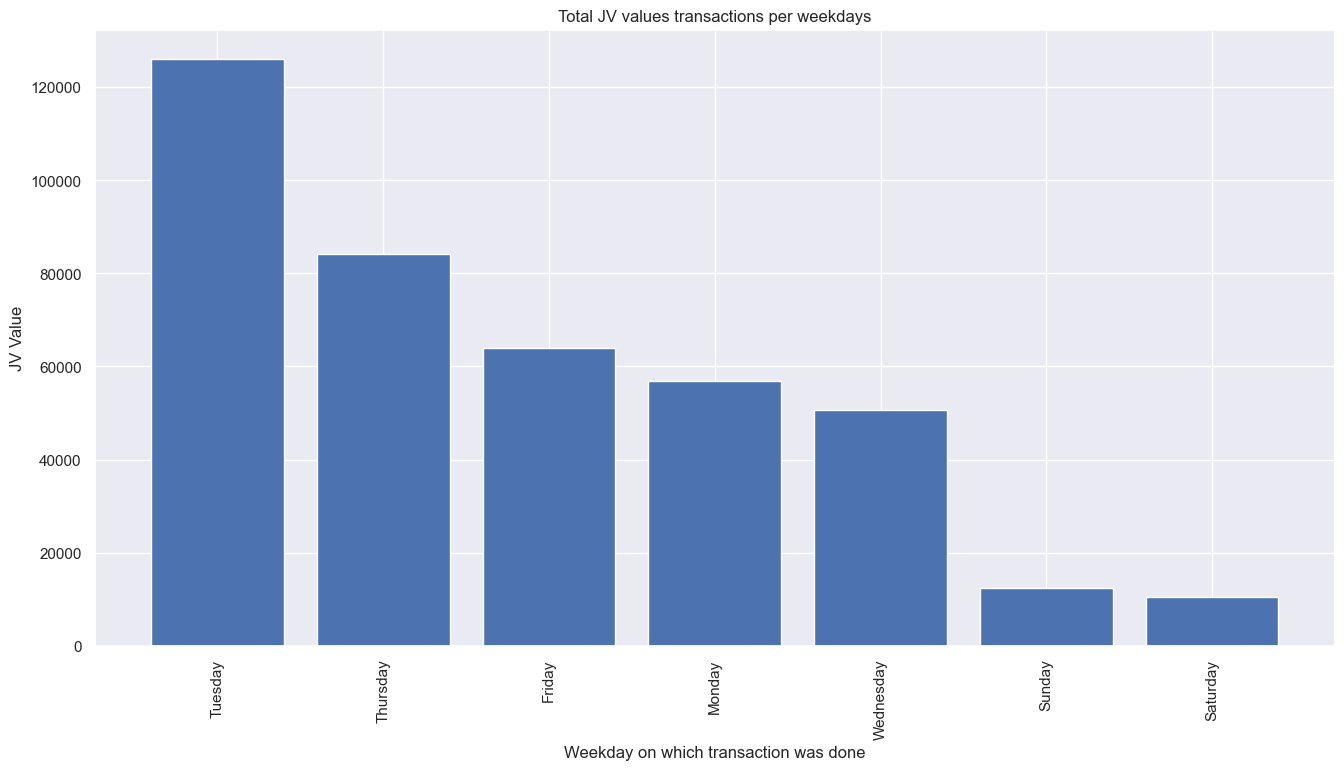

In [18]:
show_bar_plot(df,'transaction_weekday', 'JV Value', 'sum', 'JV Value', 'Weekday on which transaction was done', 
              'JV Value', "Total JV values transactions per weekdays",top=0)

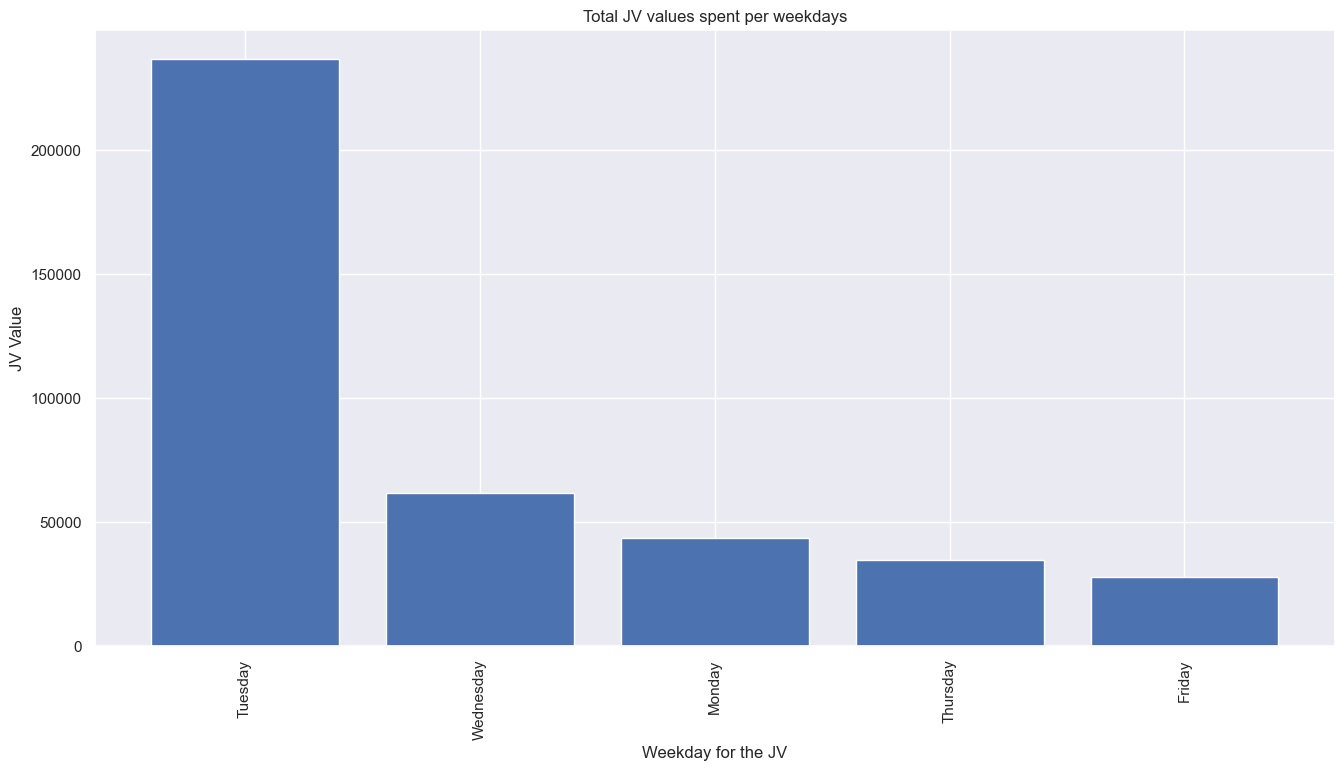

In [19]:
show_bar_plot(df,'jv_weekday', 'JV Value', 'sum', 'JV Value', 'Weekday for the JV', 
              'JV Value', "Total JV values spent per weekdays",top=0)

In [20]:
grouped_df=df.groupby(['Service Area', 'Creditor'],as_index=False).agg({'JV Value':'count'}).sort_values('JV Value',
                                                                                                ascending=False)    
grouped_df.head(20)

,Service Area,Creditor,JV Value
79,Children's Education & Skills,WWW.FLEETMINICABS.C,131
117,Children's Family Services,Amazon Mktplce EU-U,95
283,Children's Family Services,SAINSBURYS S/MKT,86
456,Childrens Services,B Q,77
452,Childrens Services,ASDA SUPERSTORE,72
113,Children's Family Services,ASDA SUPERSTORE,71
551,Childrens Services,JS ONLINE GROCERY,68
455,Childrens Services,Amazon Mktplce EU-U,66
1101,Family Services,SAINSBURYS S/MKT,65
645,Childrens Services,SAINSBURYS S/MKT,61


### Categorization by service area

In [21]:
df.head()

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value,transaction_month,transaction_day,transaction_weekday,transaction_year,jv_month,jv_day,jv_weekday,jv_year
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93,2014-05-20,143.81,4,23,Wednesday,2014,5,20,Tuesday,2014
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111,2014-05-20,6000.00,3,4,Tuesday,2014,5,20,Tuesday,2014
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6,2014-05-20,309.38,2,4,Tuesday,2014,5,20,Tuesday,2014
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7,2014-05-20,218.76,2,4,Tuesday,2014,5,20,Tuesday,2014
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381,2014-05-20,306.00,4,15,Tuesday,2014,5,20,Tuesday,2014


In [22]:
from collections import Counter
Counter(df['Service Area'])

Counter({'Childrens Services': 1297,
         'Control Accounts': 8,
         'Street Scene': 39,
         'Governance': 8,
         'Deputy Chief Operating Officer': 113,
         'Public Health': 2,
         'Adults and Communities': 53,
         'Internal Audit & CAFT': 11,
         'NSCSO': 3,
         'CSG Managed Budget': 36,
         'Strategic Commissioning Board': 1,
         'Family Services': 770,
         "Children's Service DSG": 78,
         'Education': 95,
         'Commercial': 9,
         "Children's Family Services": 1204,
         'Commissioning': 73,
         'Streetscene': 62,
         'Parking & Infrastructure': 3,
         "Children's Education & Skills": 237,
         'Customer Support Group': 32,
         'Assurance': 7,
         'Regional Enterprise': 1})

In [23]:
services_to_drop=['Public Health', 'Strategic Commissioning Board', 'Regional Enterprise', 
                  'Parking & Infrastructure', 'NSCSO']

In [24]:
drop_less_services=False

if drop_less_services:
    df1 = df.drop(df[df['Service Area'].isin(services_to_drop)].index)
else:
    df1=df

df1.shape

(4142, 15)

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
le={}
cols_to_encode=['Service Area', 'Account Description', 'Creditor', 'transaction_weekday', 'jv_weekday']
for col in cols_to_encode:
    le[col]=LabelEncoder()
    df1[col]=le[col].fit_transform(df1[col])
df1.head()

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value,transaction_month,transaction_day,transaction_weekday,transaction_year,jv_month,jv_day,jv_weekday,jv_year
0,6,15,15,2014-04-23,93,2014-05-20,143.81,4,23,6,2014,5,20,3,2014
1,6,20,23,2014-03-04,111,2014-05-20,6000.00,3,4,5,2014,5,20,3,2014
2,6,10,27,2014-02-04,6,2014-05-20,309.38,2,4,5,2014,5,20,3,2014
3,6,10,27,2014-02-04,7,2014-05-20,218.76,2,4,5,2014,5,20,3,2014
4,6,2,32,2014-04-15,381,2014-05-20,306.00,4,15,5,2014,5,20,3,2014


In [26]:
df1[df1.duplicated(keep=False)]

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value,transaction_month,transaction_day,transaction_weekday,transaction_year,jv_month,jv_day,jv_weekday,jv_year


In [30]:
from sklearn.model_selection import train_test_split
from collections import Counter

# convert raw data for X and y numpy features and labels
X=df1[['Account Description', 'Creditor', 'JV Value', 'transaction_month', 'transaction_day', 'transaction_weekday',
     'transaction_year', 'jv_month', 'jv_day', 'jv_weekday', 'jv_year']].values

y=df1['Service Area'].values
print(Counter(y))


Counter({6: 1297, 4: 1204, 13: 770, 3: 237, 11: 113, 12: 95, 5: 78, 8: 73, 22: 62, 0: 53, 21: 39, 2: 36, 10: 32, 15: 11, 7: 9, 9: 8, 14: 8, 1: 7, 16: 3, 17: 3, 18: 2, 20: 1, 19: 1})


In [31]:
# divide into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
clf=RandomForestClassifier(n_estimators=100,n_jobs=4) # fit a random forest classifier
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8588661037394452

In [33]:
preds=clf.predict(X_test)
from sklearn.metrics import classification_report # show the classification report
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

           0       0.20      0.40      0.27         5
           2       0.67      1.00      0.80         4
           3       0.55      1.00      0.71        28
           4       0.98      0.83      0.90       260
           5       0.10      0.50      0.17         4
           6       0.98      0.95      0.96       296
           8       0.36      0.80      0.50         5
           9       1.00      1.00      1.00         1
          10       0.25      0.50      0.33         2
          11       0.33      0.60      0.43        10
          12       0.28      0.50      0.36        10
          13       0.96      0.80      0.87       193
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          22       0.69    

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [34]:
feature_names=['Account Description', 'Creditor', 'JV Value', 'transaction_month', 'transaction_day', 'transaction_weekday',
     'transaction_year', 'jv_month', 'jv_day', 'jv_weekday', 'jv_year']

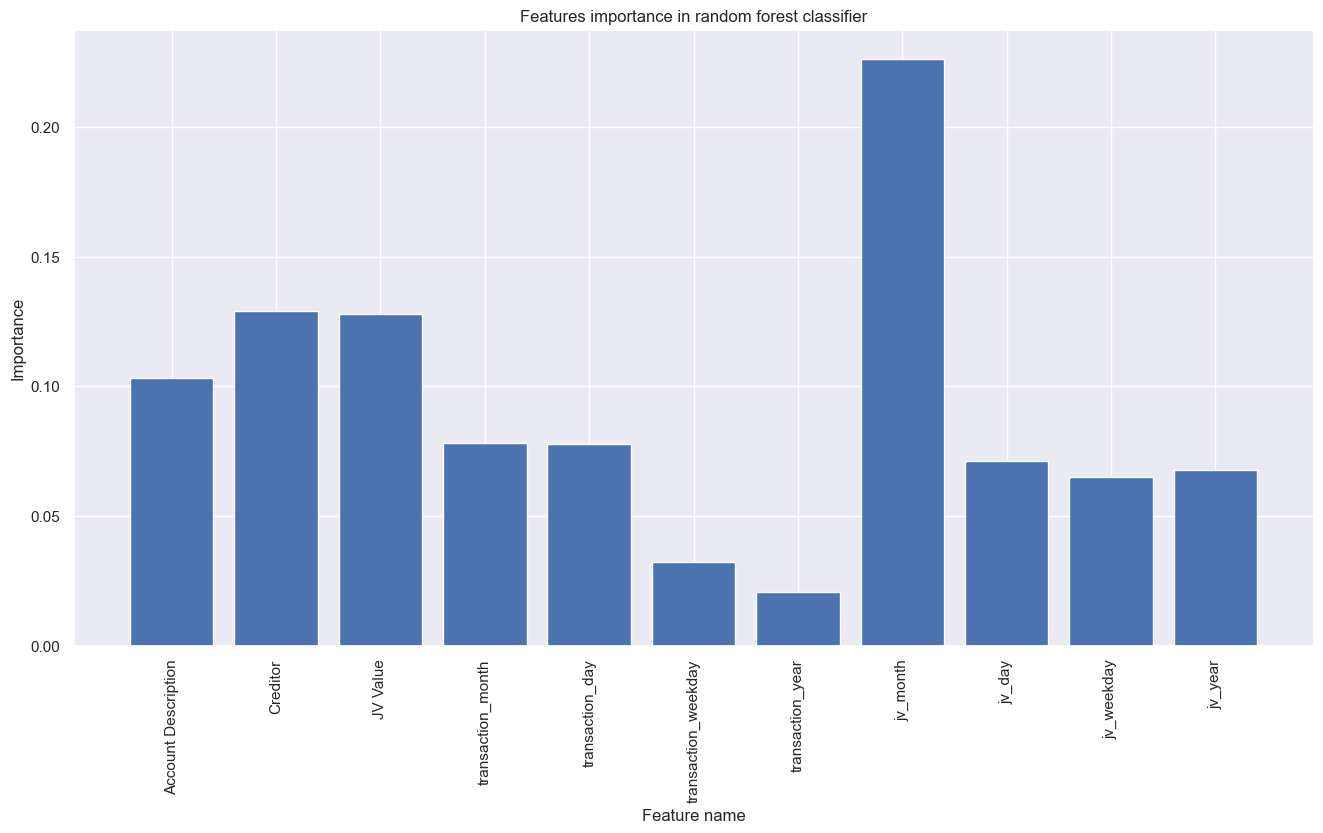

In [35]:
imp=clf.feature_importances_
plt.figure(figsize=(16,8))
plt.bar(feature_names,imp)
plt.xticks(rotation=90)
plt.title("Features importance in random forest classifier") # show feature importances
plt.xlabel("Feature name")
plt.ylabel("Importance")
plt.show()

In [76]:
explainer = shap.Explainer(clf, X_train, feature_names=feature_names) # shap explainer
shap_values = explainer(X_test) # get shap values
print(shap_values.values.shape)

100%|===================| 31423/31441 [09:36<00:00]        

(1367, 11, 23)


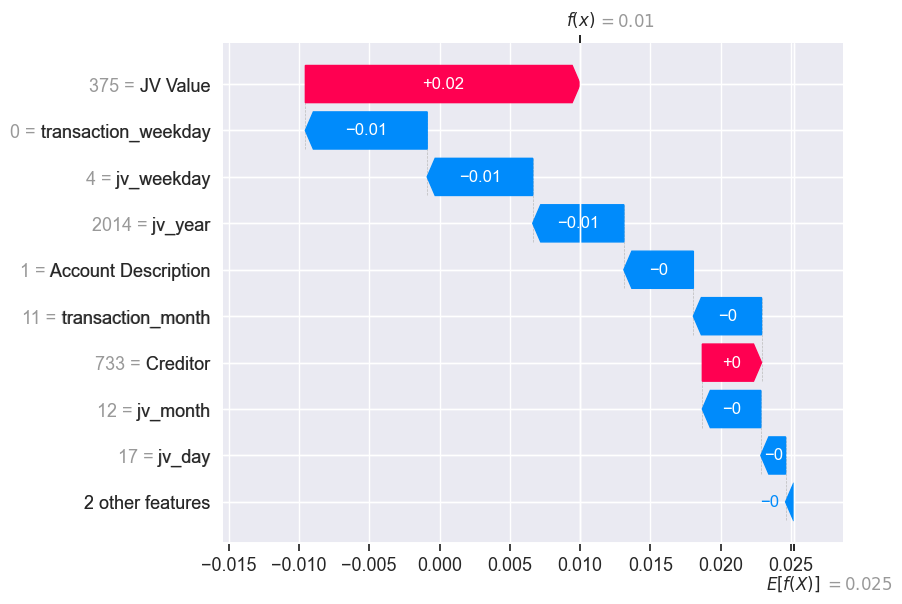

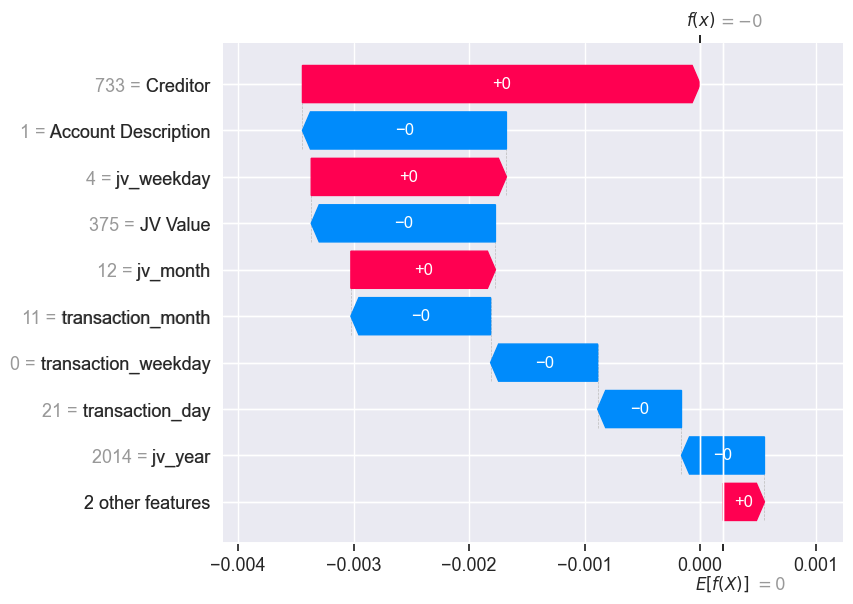

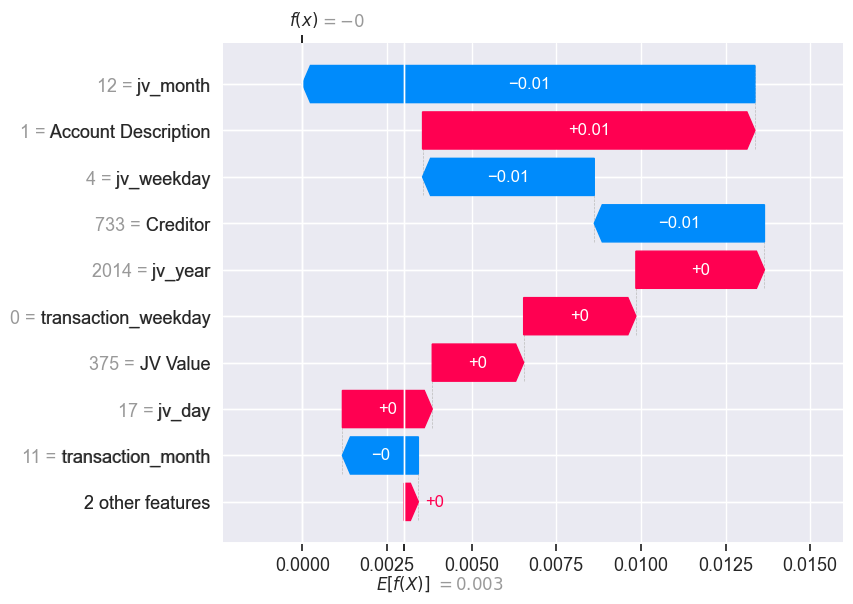

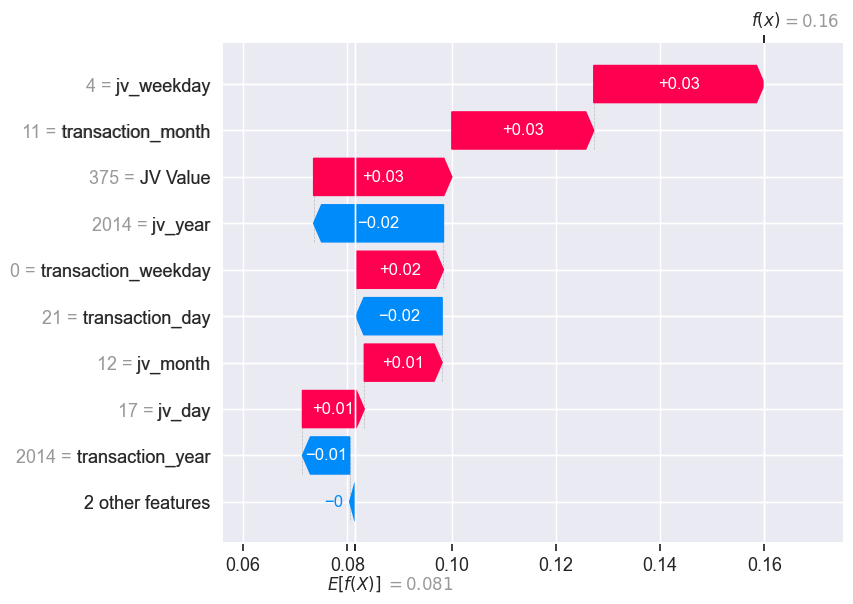

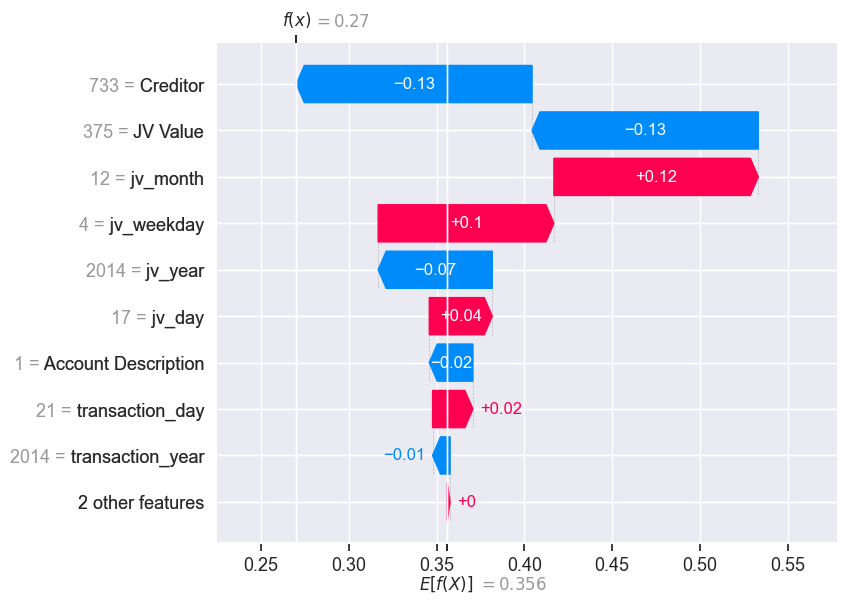

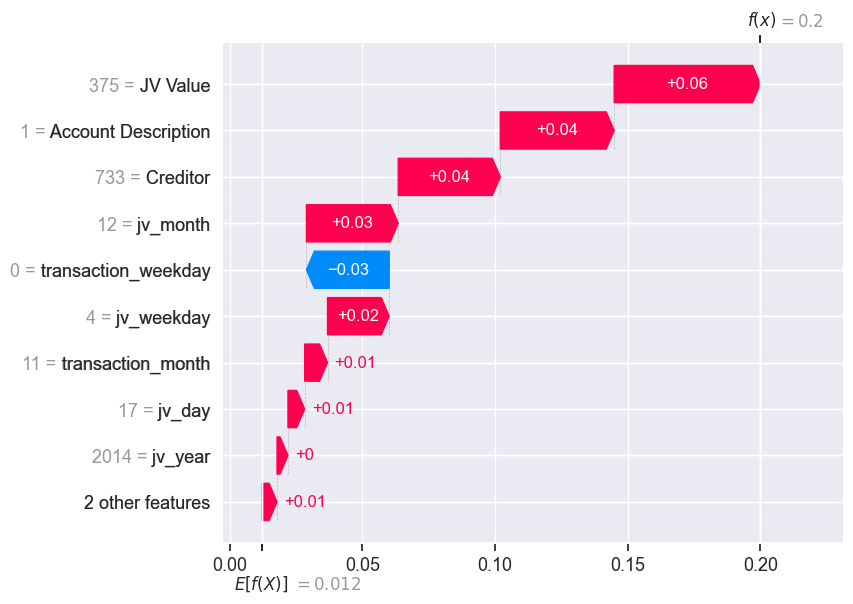

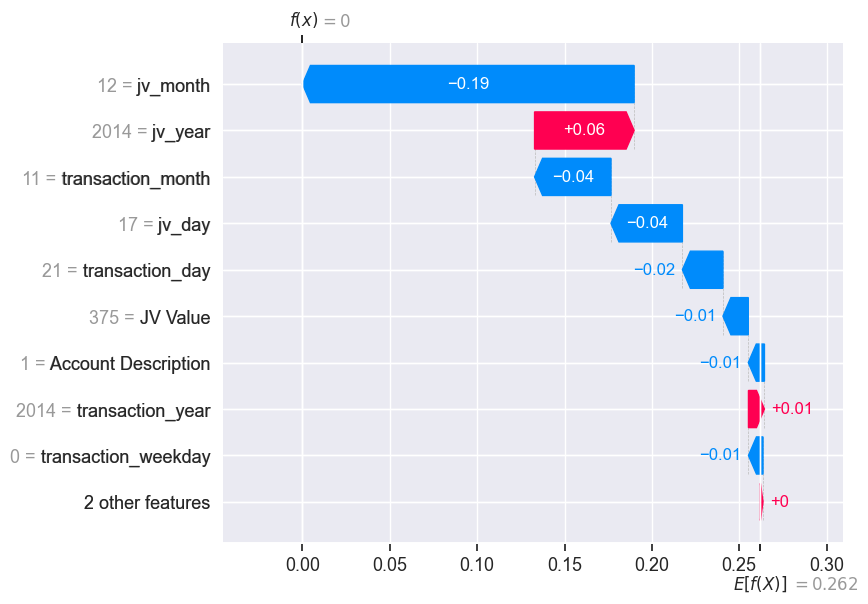

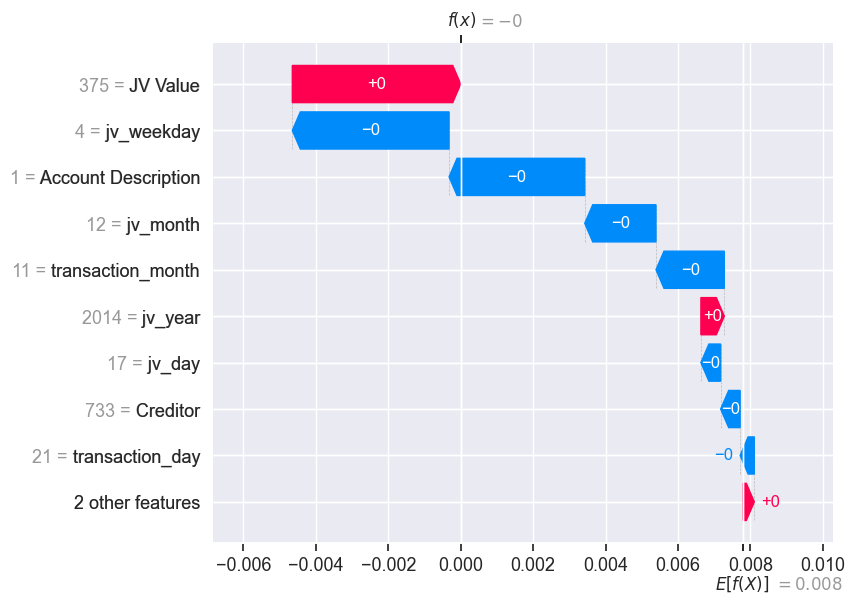

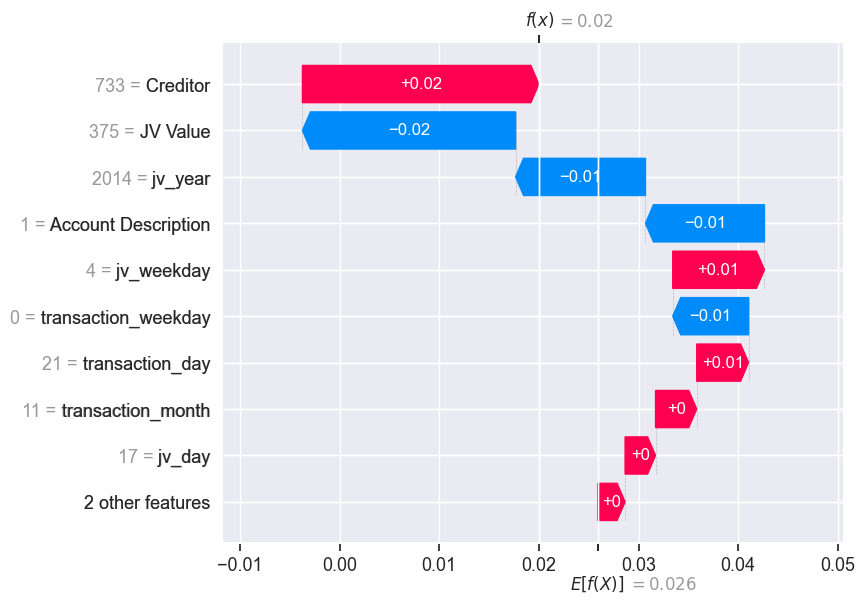

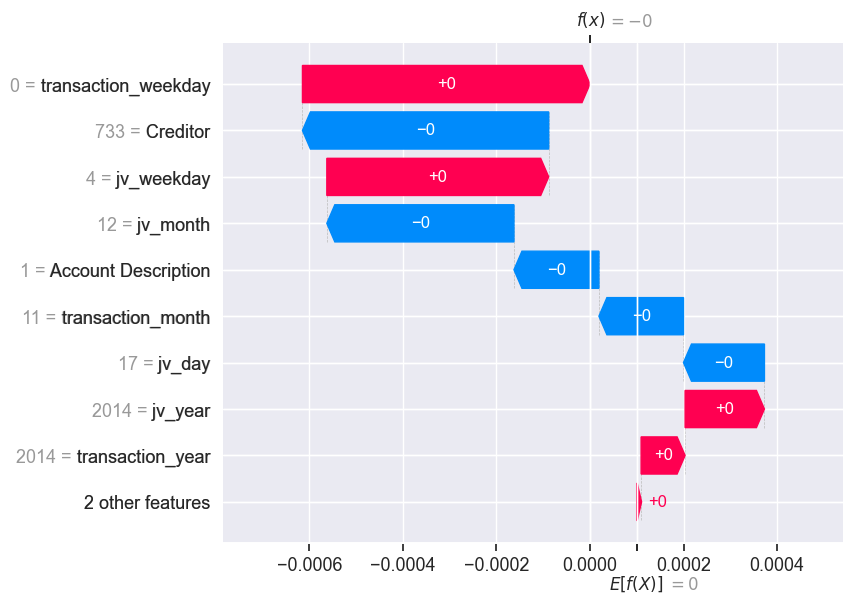

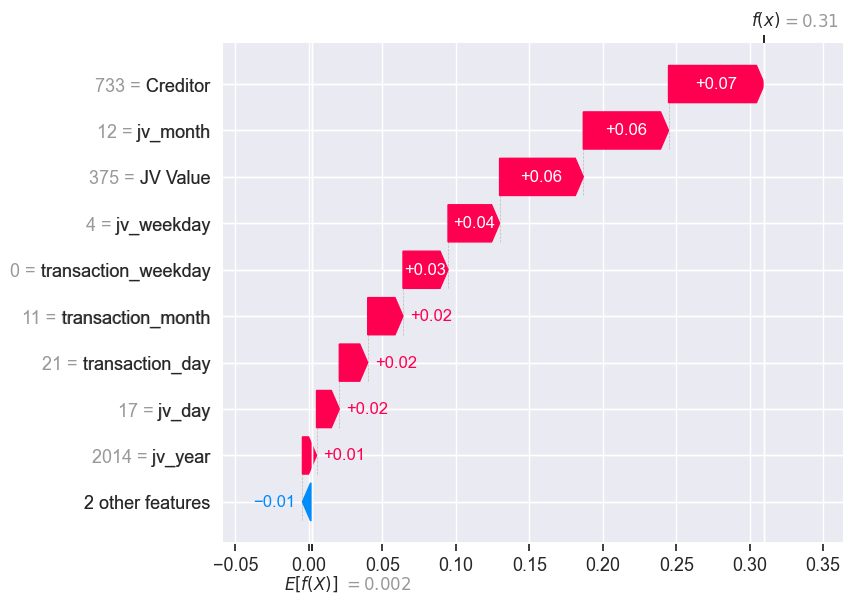

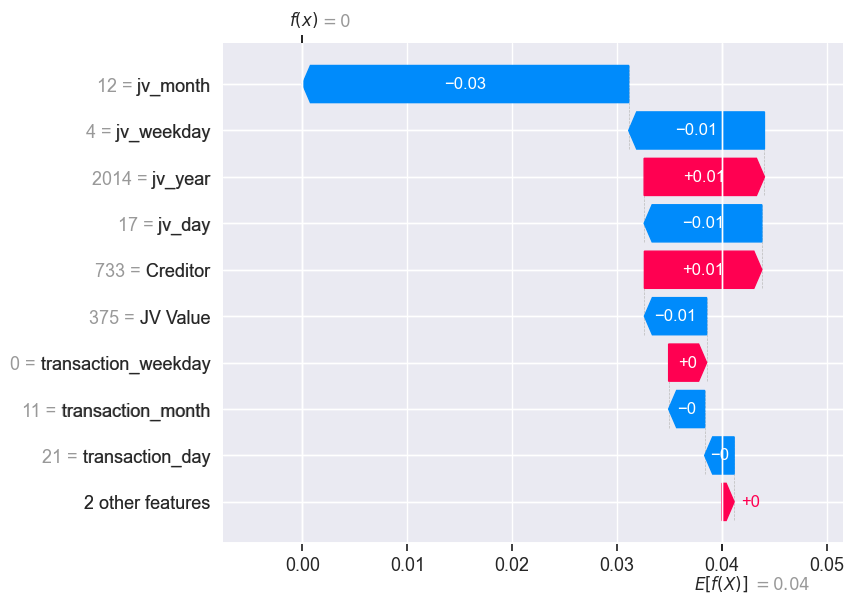

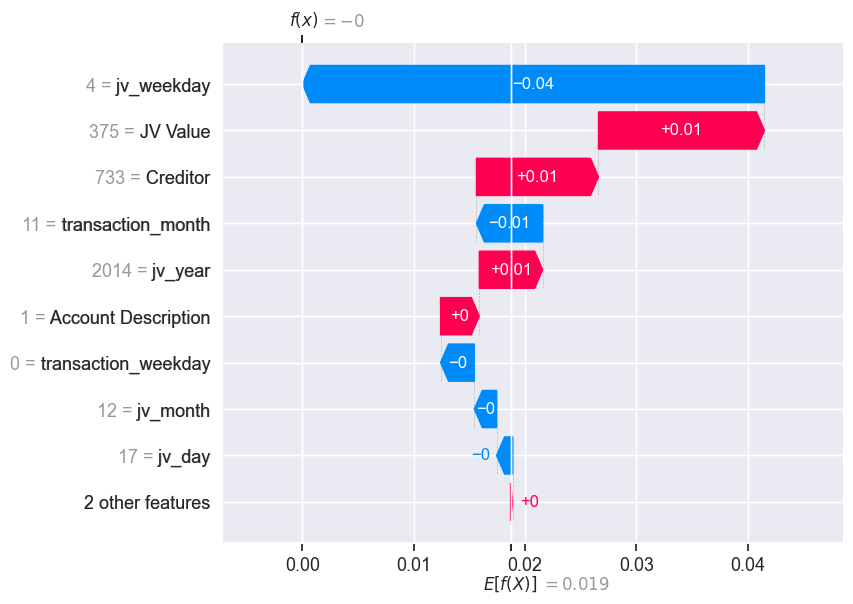

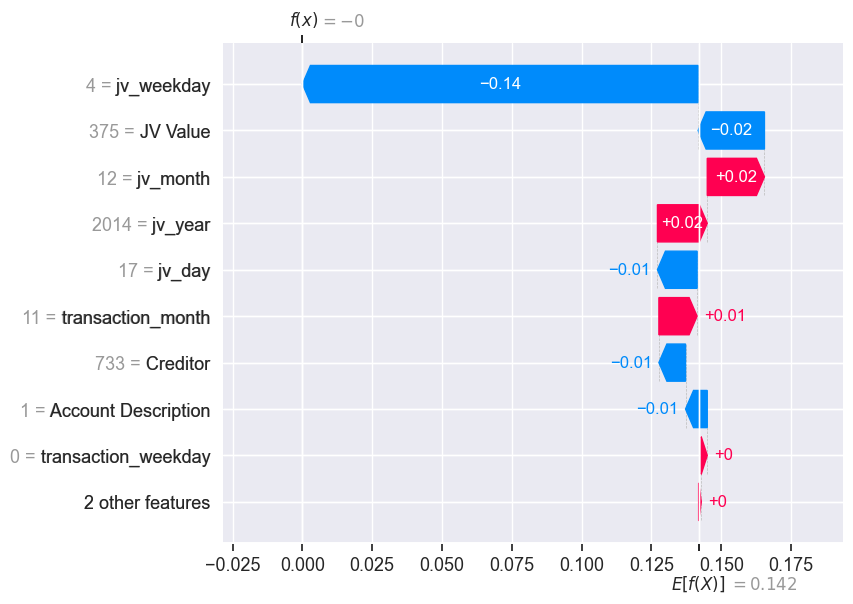

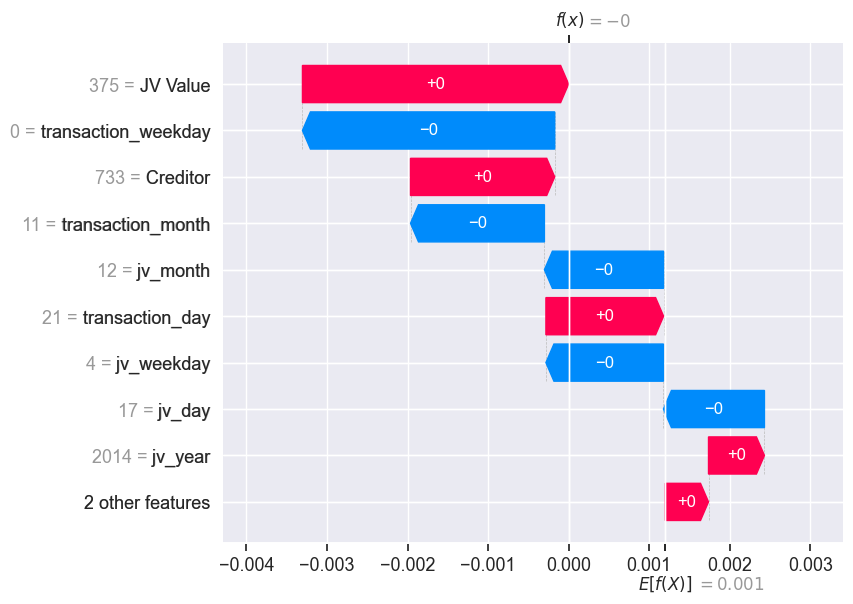

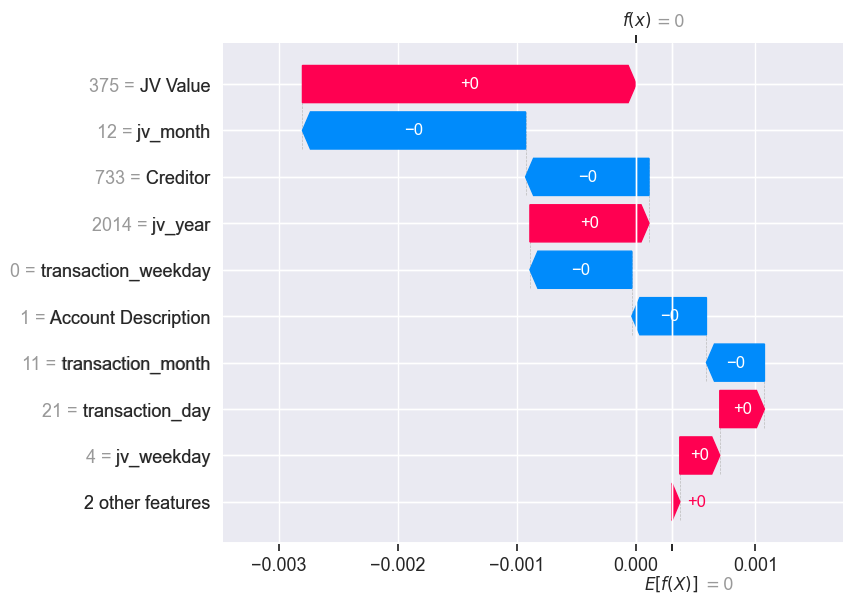

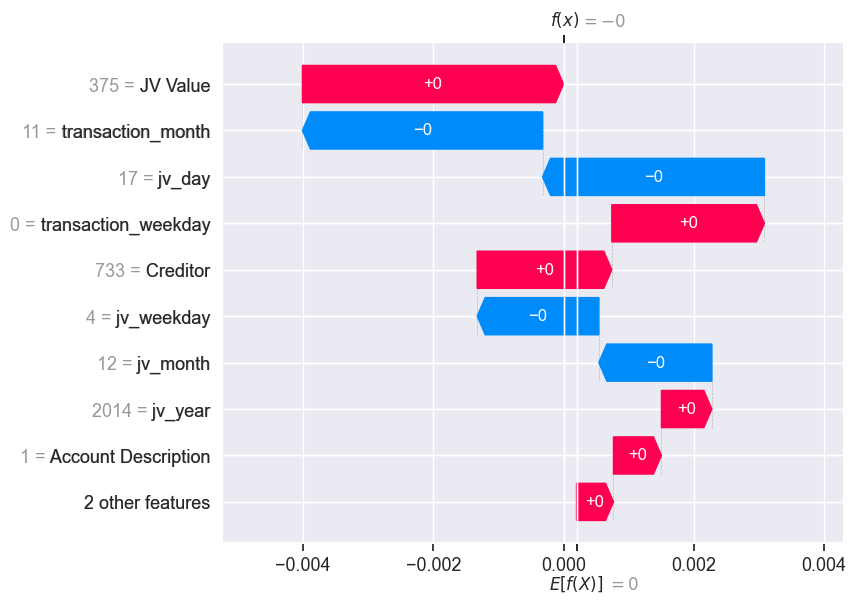

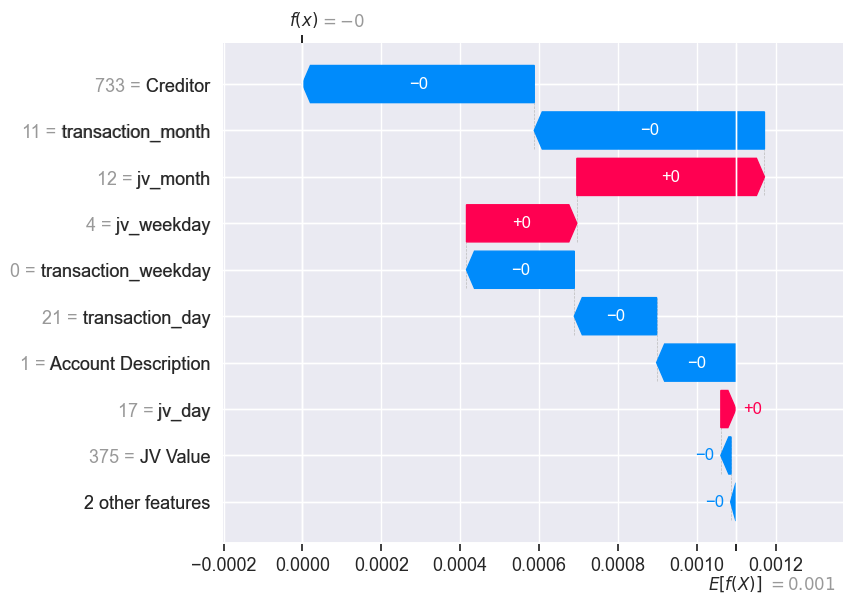

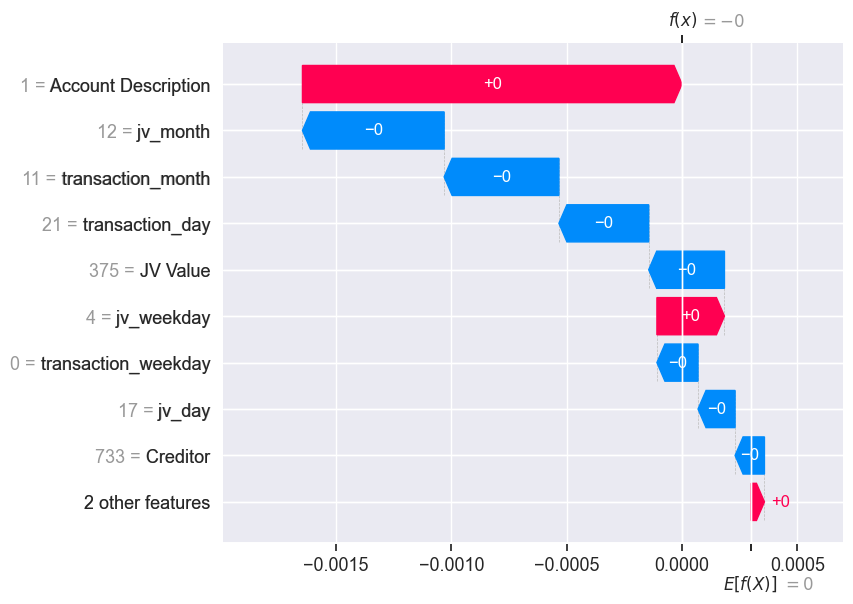

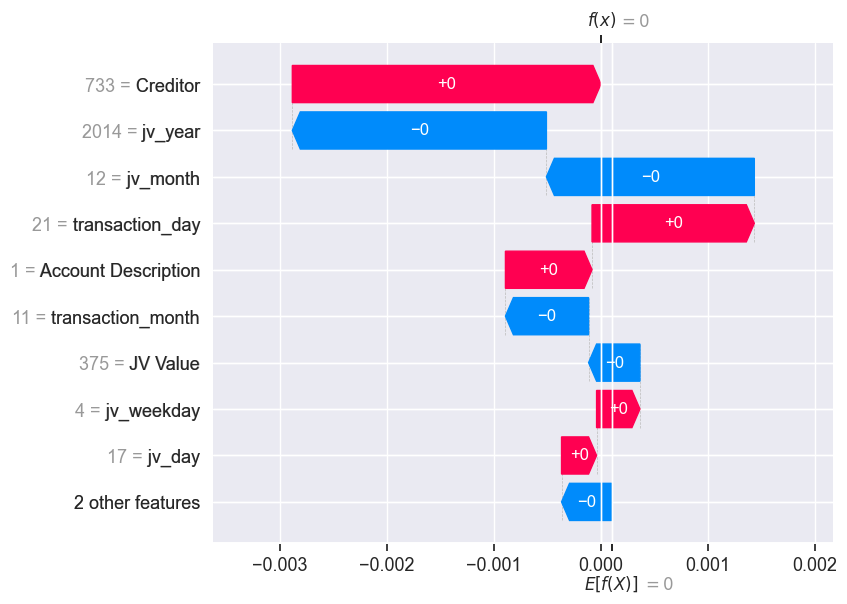

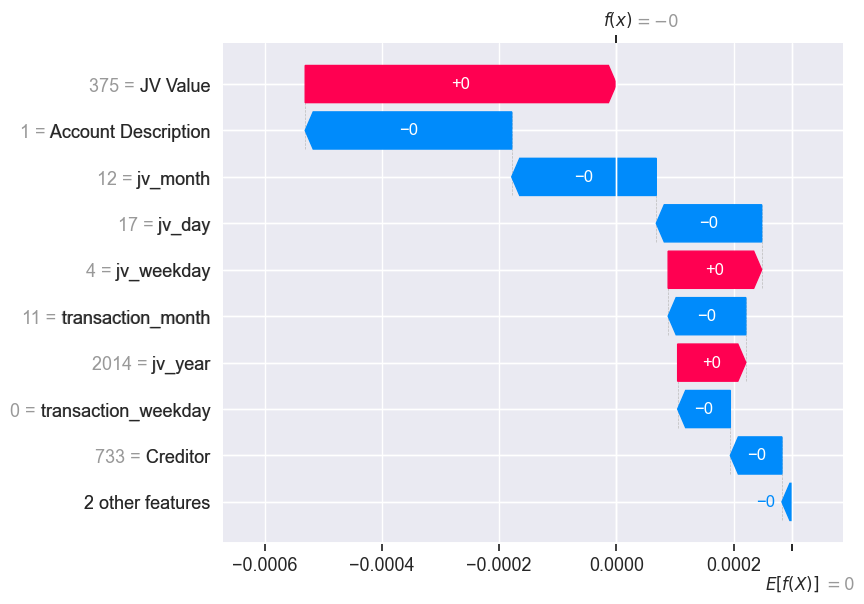

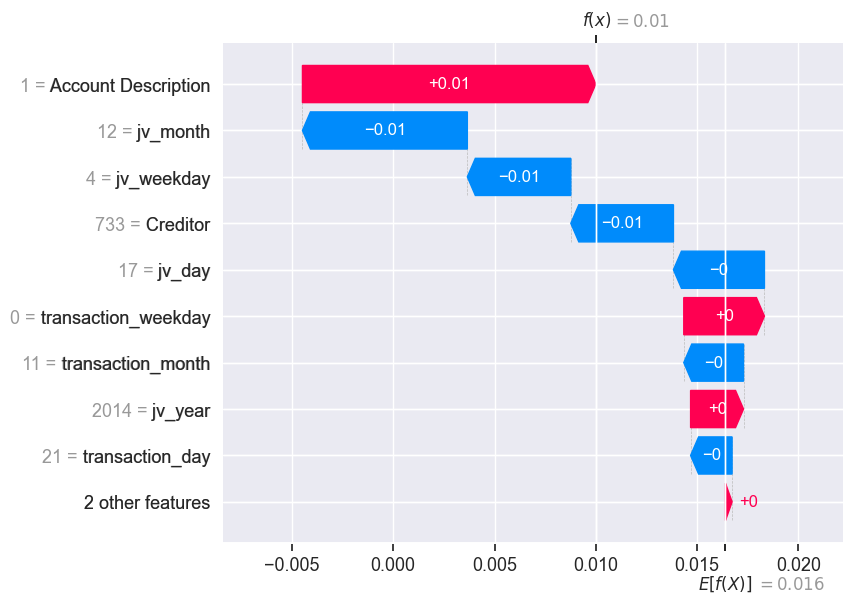

In [88]:
# shap describes the predictions, it is useful to see reasons behind the blackbox predictions
ind=50
for cl in range(22):
    shap.plots.waterfall(shap_values[ind,:,cl]) # plot shap values

### Reduction of expenditure

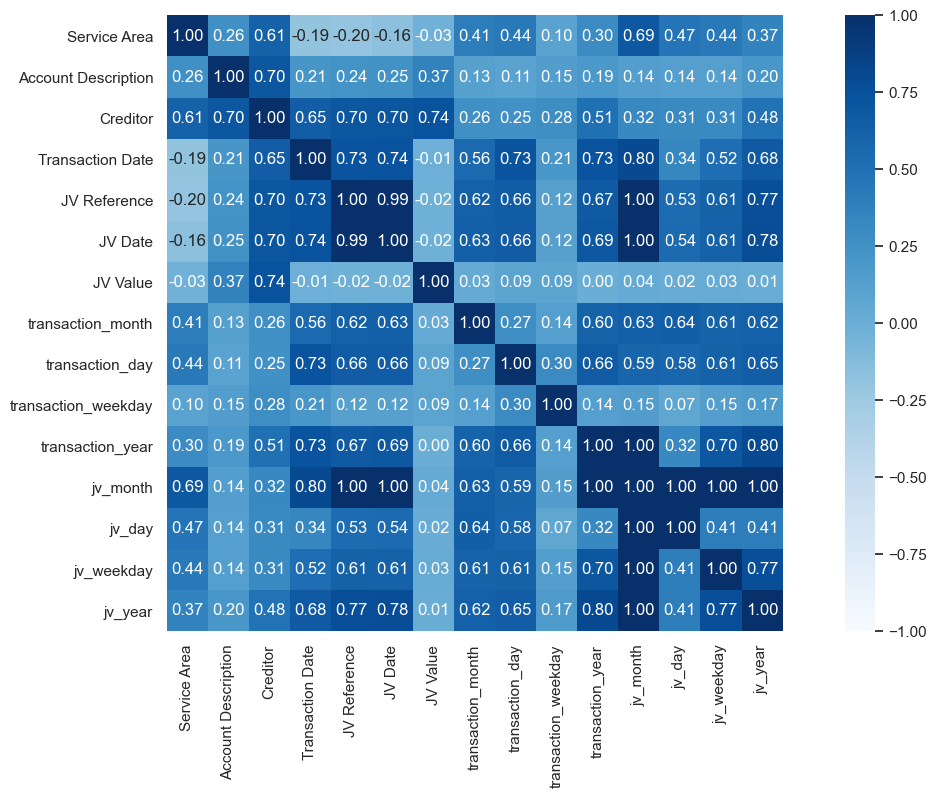

In [52]:
# find correlation between JV Value and other columns

feature_names=['Account Description', 'Creditor', 'JV Value', 'transaction_month', 'transaction_day', 'transaction_weekday',
     'transaction_year', 'jv_month', 'jv_day', 'jv_weekday', 'jv_year']

fig, ax = plt.subplots(figsize=(16, 8))

from dython.nominal import associations
corr,ax=associations(df, nominal_columns=['Account Description', 'Creditor', 'transaction_month', 
                                  'transaction_day', 'transaction_weekday', 'transaction_year',
                                  'jv_month', 'jv_day', 'jv_weekday', 'jv_year'],
                    ax = ax, cmap = "Blues")

#### JV Value has very high correlation with creditor according to the correlation matrix above. So, by ML method, to reduce the expenditures, council has to avoid the top creditors like HMCOURTS and JM_ONLINE_GROCERY, etc. These creditors are evident from the groupped bar plot above as well.